In [1]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
from xgboost import XGBClassifier, plot_tree
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
data = pd.read_csv('Datasets/heart.csv')
data.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [4]:
data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [5]:
clean_data = data.copy()

In [6]:
# Since its not possible to have 0 cholesterol, all 0 values are replaced with median values with respect to sex
male_median_cholestrol = clean_data[(clean_data['Sex'] == 'M') & (clean_data['Cholesterol'] > 0)]['Cholesterol'].median()
female_median_cholestrol = clean_data[(clean_data['Sex'] == 'F') & (clean_data['Cholesterol'] > 0)]['Cholesterol'].median()
clean_data.loc[(clean_data['Cholesterol'] == 0) & (clean_data['Sex'] == 'M'), 'Cholesterol'] = male_median_cholestrol
clean_data.loc[(clean_data['Cholesterol'] == 0) & (clean_data['Sex'] == 'F'), 'Cholesterol'] = female_median_cholestrol
# Similarly as resting blood pressure cannot be 0, all 0 values are replaced with median values with respect to sex
male_median_RestingBP = clean_data[(clean_data['Sex'] == 'M') & (clean_data['RestingBP'] > 0)]['RestingBP'].median()
female_median_RestingBP = clean_data[(clean_data['Sex'] == 'F') & (clean_data['RestingBP'] > 0)]['RestingBP'].median()
clean_data.loc[(clean_data['RestingBP'] == 0) & (clean_data['Sex'] == 'M'), 'RestingBP'] = male_median_RestingBP
clean_data.loc[(clean_data['RestingBP'] == 0) & (clean_data['Sex'] == 'F'), 'RestingBP'] = female_median_RestingBP

In [7]:
clean_data.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.538126,242.810458,0.233115,136.809368,0.887364,0.553377
std,9.432617,17.990127,53.474043,0.423046,25.460334,1.066570,0.497414
min,28.000000,80.000000,85.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,214.000000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,234.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [8]:
# Removing and replacing outliers with median wherever applicable 
clean_col = ['RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
for col in clean_col:
    Q1 = clean_data[col].quantile(0.25)
    Q3 = clean_data[col].quantile(0.75)
    IQR = Q3-Q1
    high = Q3 + 1.5*IQR
    low = Q1 - 1.5*IQR
    clean_data[col] = clean_data[col].astype(float)
    median_val = clean_data[col].median()
    clean_data.loc[(clean_data[col] < low) | (clean_data[col] > high), col] = median_val

In [9]:
def one_hot_encode(df, col):
    encoded_df = df.copy()
    encoded_df = pd.get_dummies(data=df, columns=col, prefix=col, dtype=int)
    return encoded_df

In [10]:
cat_col = clean_data.select_dtypes(exclude='number').columns
for col in cat_col: 
    print(clean_data[col].value_counts())
clean_data['HeartDisease'].value_counts()

Sex
M    725
F    193
Name: count, dtype: int64
ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
RestingECG
Normal    552
LVH       188
ST        178
Name: count, dtype: int64
ExerciseAngina
N    547
Y    371
Name: count, dtype: int64
ST_Slope
Flat    460
Up      395
Down     63
Name: count, dtype: int64


HeartDisease
1    508
0    410
Name: count, dtype: int64

In [11]:
encoded_data = one_hot_encode(clean_data, cat_col)
encoded_data.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease,Sex_F,Sex_M,ChestPainType_ASY,...,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140.0,289.0,0,172.0,0.0,0,0,1,0,...,0,0,0,1,0,1,0,0,0,1
1,49,160.0,180.0,0,156.0,1.0,1,1,0,0,...,1,0,0,1,0,1,0,0,1,0
2,37,130.0,283.0,0,98.0,0.0,0,0,1,0,...,0,0,0,0,1,1,0,0,0,1
3,48,138.0,214.0,0,108.0,1.5,1,1,0,1,...,0,0,0,1,0,0,1,0,1,0
4,54,150.0,195.0,0,122.0,0.0,0,0,1,0,...,1,0,0,1,0,1,0,0,0,1


In [12]:
x = encoded_data.drop(columns=['HeartDisease'])
y = encoded_data['HeartDisease'].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

In [13]:
models = {
    'XGBoost' : (XGBClassifier(eval_metric='logloss', random_state=42),
                 {
                     'n_estimators': [100, 200, 400],
                     'max_depth' : [3, 5, 7],
                     'learning_rate' : [0.05, 0.1, 0.2]
                 }), 
    'RandomForest' : (RandomForestClassifier(random_state=42),
                      {
                        'n_estimators': [100, 200, 400],
                        'max_depth' : [3, 5, 7]
                      })
}

best_models = {}

for model_name, (model, params) in models.items():
    
    grid = GridSearchCV(
        estimator=model, 
        param_grid=params,
        cv=5,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    grid.fit(x_train, y_train)

    best_model = grid.best_estimator_
    y_prediction = best_model.predict(x_test)
    model_accuracy = accuracy_score(y_pred=y_prediction, y_true=y_test)

    best_models[model_name] = {
        'best_estimator' : grid.best_estimator_,
        'best_parameters' : grid.best_params_,
        'best_cross_validation_score' : grid.best_score_,
        'model_accuracy' : model_accuracy
    } 



Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


In [14]:
for name, results in best_models.items():
    print(f'{name}')
    print(f'Best parameters: {results['best_parameters']}')
    print(f'Best cross validation score: {results['best_cross_validation_score']}')
    print(f'Model Accuracy: {results['model_accuracy']}')

XGBoost
Best parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Best cross validation score: 0.8647625092563208
Model Accuracy: 0.8869565217391304
RandomForest
Best parameters: {'max_depth': 7, 'n_estimators': 200}
Best cross validation score: 0.8719983074156353
Model Accuracy: 0.8608695652173913


<Axes: >

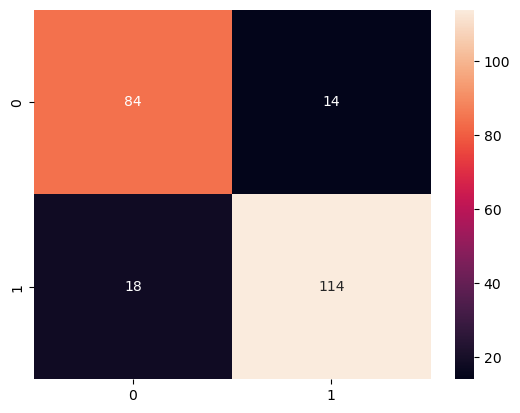

In [27]:
cm = confusion_matrix(y_true=y_test, y_pred=y_prediction)
sns.heatmap(cm, annot=True, fmt='.0f')

In [31]:
cr = classification_report(y_true=y_test, y_pred=y_prediction, output_dict=True)
pd.DataFrame(cr)

,0,1,accuracy,macro avg,weighted avg
precision,0.823529,0.890625,0.86087,0.857077,0.862036
recall,0.857143,0.863636,0.86087,0.860390,0.860870
f1-score,0.840000,0.876923,0.86087,0.858462,0.861191
support,98.000000,132.000000,0.86087,230.000000,230.000000
